In [ ]:
########################################################################
# Author    : A. Alsema
# Date      : Augustus 2021
# Dataset   : pseudobulked lesion cores, lesion rims and PLWM from Visium Spatial Transcriptomics for MS lesions
# Purpose   : between donor comparison, differential analysis with dream-limma. GLMM model to account for slide and donor effect  

# Required inputs: 
# - Countfile_WM.csv : containing count table with pseudobulk samples 
# - WM_Targetfile_2023.csv: csv file with information about samples
# - form.NAWM: a design formula suitable to the dream differential expression analysis.
# For further information please refer to https://www.bioconductor.org/packages/devel/bioc/vignettes/variancePartition/inst/doc/dream.html
# Output    : csv files with differentially expressed genes 

########################################################################

In [5]:
rm(list = ls())
setwd("<your_datadir>")

# note: PLWM mixed act/inact is of lower brain pH and Age than the NAWM, correct for those variables
form.NAWM <- ~ Group + brain_pH + Age + (1|Slide_ID) + (1|donor_ID)

library('variancePartition')
library('edgeR')
library('BiocParallel')
library('ggplot2')
library('RColorBrewer')

In [2]:
# Specify parallel processing parameters
# this is used implicitly by dream() to run in parallel
param = SnowParam(4, "SOCK", progressbar=TRUE)
register(param)

outdir = "conditionX_vs_NAWM/"


In [3]:
#################################################################
#' Process Limma tables to store Differential Expression Analysis
#'
#' Optional custom function
#' This function processes a limma result to identify upregulated and downregulated genes based on specified 
#' FDR and log2 fold change thresholds. It outputs two text files containing the lists of upregulated and 
#' downregulated genes that pass the threshold values.
#'
#' @param limmatable derived from limma::toptable()
#' @param textname A character string specifying the name of the comparison to be used in output file names.
#' @param FDRval A numeric value representing the FDR (False Discovery Rate) threshold.
#' @param logFCval A numeric value representing the log2 fold change threshold.
#'
#' @return A list with two elements:
#' \describe{
#'   \item{up}{A data frame of upregulated genes passing the threshold values.}
#'   \item{down}{A data frame of downregulated genes passing the threshold values.}
#' }
#' 
#' @export
#'
#' @examples
#' # Assuming 'limma_results' is a table outputted by limma::toptable() with appropriate columns (adj.P.Val and logFC)
#' limma_tables(limmatable = top_table, textname = "PLWM-active_vs_NAWM", FDRval = 0.05, logFCval = 1)

limma_tables <- function(limmatable, textname, FDRval, logFCval){
  mygenes <- limmatable[!rowSums(is.na(limmatable)) > 1, ] # Remove rows with more than one NA value
  
  # Upregulated genes
  upTable <- which(mygenes$adj.P.Val < FDRval & mygenes$logFC > logFCval)
  upTable <- mygenes[upTable,] # Table of genes satisfying logFC and p-value criteria for upregulation
  write.csv(upTable, file =  paste(textname,"_up.csv", sep=""), quote = FALSE)
  
  # Downregulated genes
  downTable <- which(mygenes$adj.P.Val < FDRval & mygenes$logFC < -1 * logFCval)
  downTable <- mygenes[downTable,] # Table of genes satisfying logFC and p-value criteria for downregulation
  write.csv(downTable, file =  paste(textname,"_down.csv", sep=""))
  
  return(list("up" = upTable, "down" = downTable))
}

In [6]:
#################################################################
### load the raw counts
#################################################################
countfile <- read.csv(file = "Countfile_WM.csv", row.names = 1)
# create coldata
target <- read.csv(file = "WM_Targetfile_2023.csv", sep=",", header = T, row.names = 1, stringsAsFactors = F)

# remove some unused samples
to_drop <- c("ST34_low_nr_counts", "ST37_low_nr_counts", "ST71_GM", "ST73_GM", "ST79_GM")
countfile <- countfile[, !colnames(countfile) %in% to_drop]

# check
ncol(countfile)
nrow(target)
# reorder the target file
target <- target[match(colnames(countfile), rownames(target)) ,]

#should be true
identical(colnames(countfile), rownames(target) )

target$Sample_ID <- factor(target$Sample_ID)
target$Group <- factor(target$Group, levels = c("NAWM", "CWM", 
                                                "PL_act.inact", "act.inact", "RIM_act.inact", 
                                                "PL_Active", "Active", "RIM_Active"))
unique(target$Group)
target$Sample_ID <- factor(target$Sample_ID)
target$group_donor <- paste(target$Group, target$donor_ID, sep = "_")
target$donor_ID <- factor(target$donor_ID)
target$Slide_ID <- factor(target$Slide_ID)
target$Sex <- factor(target$Sex)

identical(colnames(countfile), target$Unique_ID)
target <- target[match(colnames(countfile), rownames(target)) , ]

#################################################################
### filter genes by number of counts
#################################################################
# gene needs to be expressed 
0.7 * nrow(target) # this treshold means  70% of the samples should have detectable expression of a gene.
threshold <- round(0.7 * nrow(target)) # 0.7 is an edgeR developer recommendation,

[1] 35

[1] 35

[1] TRUE

[1] CWM           PL_Active     RIM_Active    Active        NAWM         
[6] act.inact     RIM_act.inact PL_act.inact 
8 Levels: NAWM CWM PL_act.inact act.inact RIM_act.inact PL_Active ... RIM_Active

[1] FALSE

[1] 24.5

In [7]:
isexpr = rowSums(cpm(countfile)>0.1) >= threshold # usually around 0.7 * nrow(target), recommended.
table(isexpr) # usually 1/3 to 1/2 of the geenes are too lowly expressed in ST data

isexpr
FALSE  TRUE 
17081 16457 

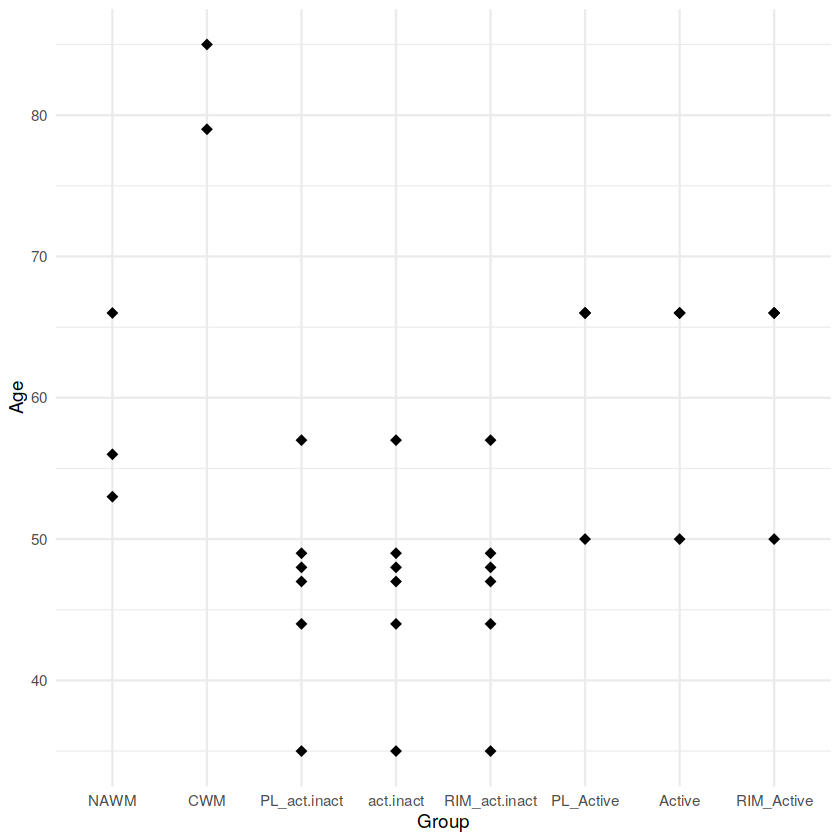

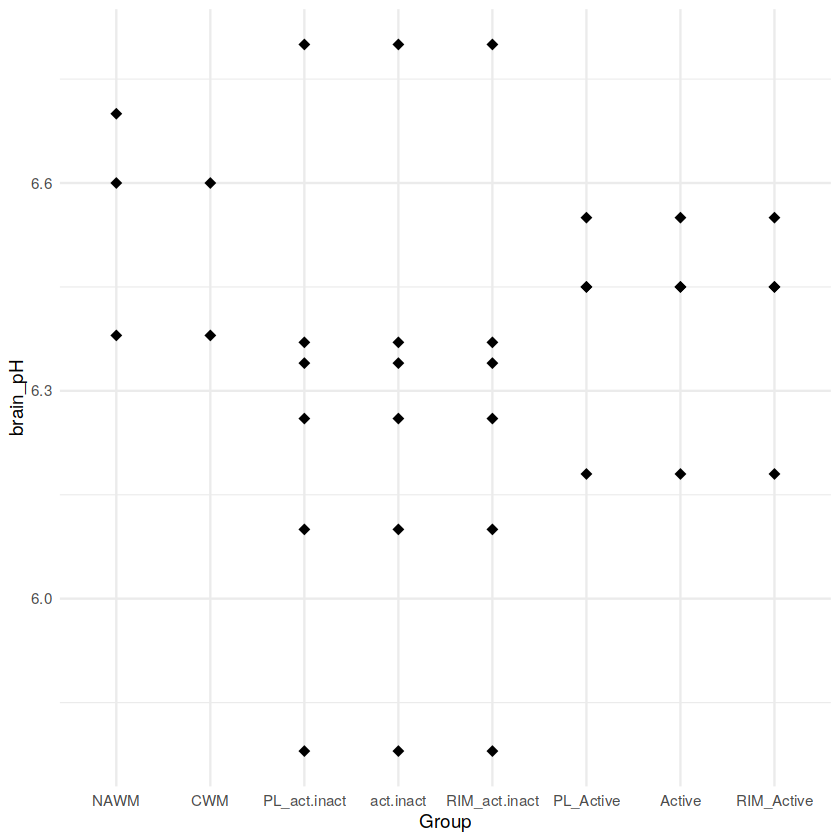

In [8]:
# check the distribution of variables age, csf_ph across group

ggplot(target, aes(x= Group, y = Age)) + 
    geom_point(shape = 18, size=3) + theme_minimal()

# check the distribution of variables age, csf_ph across group

ggplot(target, aes(x= Group, y = brain_pH)) + 
    geom_point(shape = 18, size=3)  + theme_minimal()

In [7]:
# Standard usage of limma/voom before applying variance partition
geneExpr = DGEList(counts = countfile[isexpr,] ,
                  samples= target)

In [8]:
#################################################################
### normalize for lib size
#################################################################
geneExpr = calcNormFactors( geneExpr, method = "RLE") # 

In [10]:
vobjDream

,group,lib.size,norm.factors,Sample_ID,Group,Slide_ID,donor_ID,Age,Seks,RIN,CSF_pH,PMD,PMD_min,group_donor
,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<chr>
ST31_CWM,CWM_2012-070,6782868.9,1.0588258,ST31,CWM,1,2012-070,79,M,7.70,6.38,5.45,345,CWM_2012-070
ST32_CWM,CWM_2012-088,6754559.0,0.9964383,ST32,CWM,1,2012-088,85,F,7.20,6.60,6.25,385,CWM_2012-088
ST33_PL_active,PL_Active_2011-077,5035304.4,0.9991966,ST33,PL_Active,1,2011-077,66,F,8.60,6.45,9.35,575,PL_Active_2011-077
ST33_RIM_active,RIM_Active_2011-077,1862501.4,0.9273239,ST33,RIM_Active,1,2011-077,66,F,8.60,6.45,9.35,575,RIM_Active_2011-077
ST33_active,Active_2011-077,1539703.6,0.8836865,ST33,Active,1,2011-077,66,F,8.60,6.45,9.35,575,Active_2011-077
ST34_NAWM,NAWM_2018-115,3878099.2,0.8619969,ST34,NAWM,1,2018-115,56,M,7.50,6.60,6.15,375,NAWM_2018-115
ST37_NAWM,NAWM_2011-048,4417652.5,1.0956208,ST37,NAWM,2,2011-048,53,M,6.70,6.38,10.00,600,NAWM_2011-048
ST38_NAWM,NAWM_2018-116,1918307.1,0.9068188,ST38,NAWM,2,2018-116,66,F,8.00,6.70,9.30,570,NAWM_2018-116
ST67_chronic,act.inact_2014-038,1988994.7,1.1189220,ST67,act.inact,10,2014-038,35,F,7.40,6.37,10.20,620,act.inact_2014-038


Memory usage to store result: >55.2 Mb

Dividing work into 100 chunks...

iteration: 
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100



Total:90 s



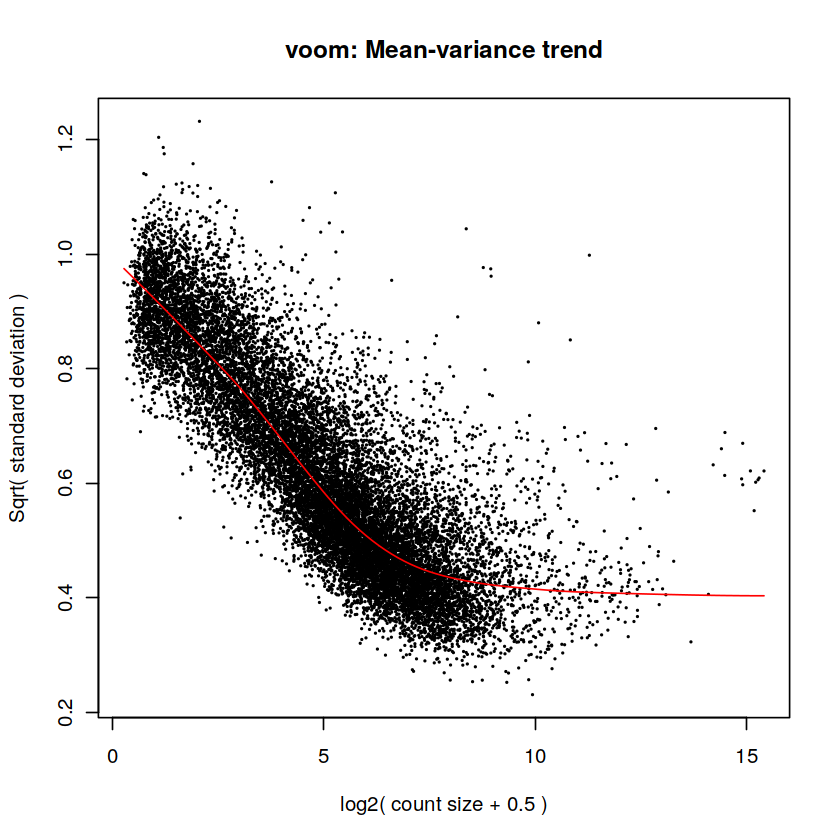

In [9]:
#################################################################
### compute gene weights and fit the mixed model
#################################################################
# estimate weights using linear mixed model of dream
vobjDream = voomWithDreamWeights( geneExpr, form.NAWM, target , plot = TRUE, BPPARAM = param)

Memory usage to store result: >55.2 Mb

Dividing work into 100 chunks...

iteration: 
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100



Total:99 s

Dividing work into 100 chunks...

iteration: 
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100



Total:930 s



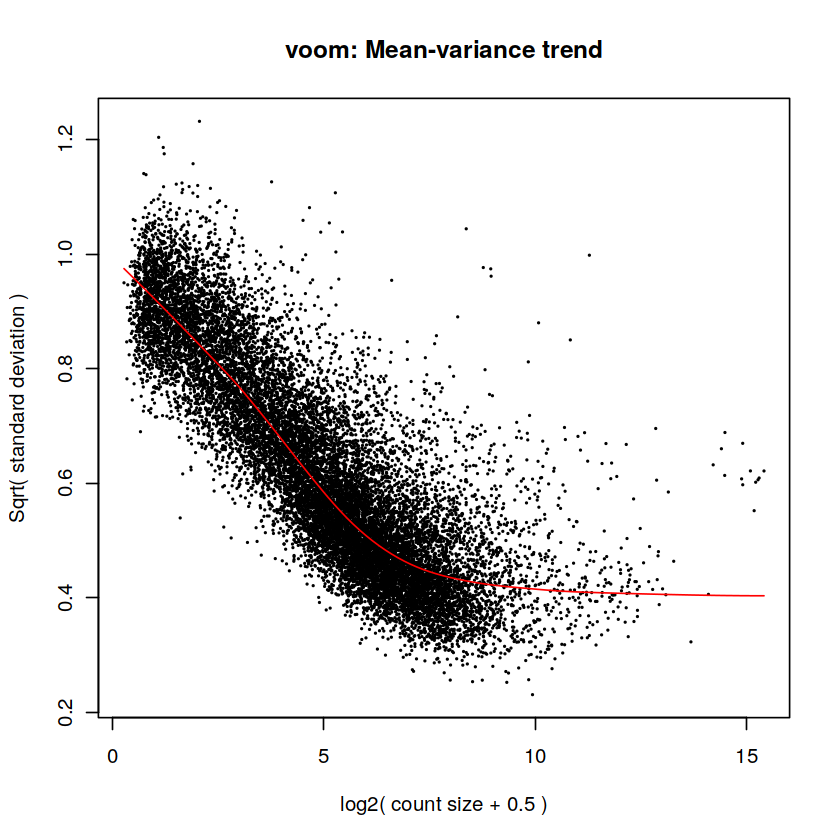

In [39]:
# reference point is NAWM and we added age as covariate.
fit = dream( vobjDream, form.NAWM, target, BPPARAM = param)

In [40]:
#################################################################
### extract the differential genes per contrast
#################################################################

################# PL-WM compared to NAWM ################


# PL- comparisons
text <- "GroupPL_Active_vs_GroupNAWM"
print(text)

top.table = topTable( fit, coef="GroupPL_Active", sort.by = "P", n = Inf)
print("Number of genes with adj.p < 0.05 and logFC > 1:")
length(which(top.table$adj.P.Val < 0.05 & top.table$logFC > 1))


res <- limma_tables(top.table, text = paste0(outdir,text), FDRval = 0.05, 1)
write.csv(top.table, file = paste0(outdir,"allgenes_", text, ".csv"))


# PL- comparisons

rm(res, top.table, text)
text <- "GroupPL_act.inact_vs_GroupNAWM"
print(text)

top.table = topTable( fit, coef="GroupPL_act.inact", sort.by = "P", n = Inf)
print("Number of genes with adj.p < 0.05 and logFC > 1:")
length(which(top.table$adj.P.Val < 0.05 & top.table$logFC > 1))


res <- limma_tables(top.table, text = paste0(outdir,text), FDRval = 0.05, 1)
write.csv(top.table, file = paste0(outdir,"allgenes_", text, ".csv"))


Warning message in rm(res, top.table, text):
“object 'res' not found”
Warning message in rm(res, top.table, text):
“object 'top.table' not found”
Warning message in rm(res, top.table, text):
“object 'text' not found”


[1] "GroupPL_Active_vs_GroupNAWM"
[1] "Number of genes with adj.p < 0.05 and logFC > 1:"


[1] 84

[1] "GroupPL_act.inact_vs_GroupNAWM"
[1] "Number of genes with adj.p < 0.05 and logFC > 1:"


[1] 25

In [41]:
sessionInfo()

R version 4.2.0 (2022-04-22)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS/LAPACK: /data/bcn/p283607/anaconda3/envs/R4.2/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] RColorBrewer_1.1-3       edgeR_3.40.2             variancePartition_1.28.4
[4] BiocParallel_1.32.6      limma_3.54.2             ggplot2_3.4.4           

loaded via a namespace (and not attached):
 [1] Biobase_2.58.0          tidyr_1.3.1             jsonlite_1.8.7         
 [4] splines_4.2.0     